In [2]:
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_data(ticker, start, end):
    data = yf.download(ticker, start, end)
    close_price = data['Close']
    returns = close_price.pct_change()
    mean_returns = returns.mean()
    cov_mat = returns.cov()
    # Correlation is normalized covariance by dividing it by the product of stdev of the two variables
    return mean_returns, cov_mat

In [4]:
stocklist = ['BRMS', 'MAPA', 'BBRI', 'DEWA', 'GOTO']
tickers = [stock + '.JK' for stock in stocklist]
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=300)

mean_returns, cov_mat = get_data(tickers, start_date, end_date)

[*********************100%***********************]  5 of 5 completed


<Axes: xlabel='Ticker', ylabel='Ticker'>

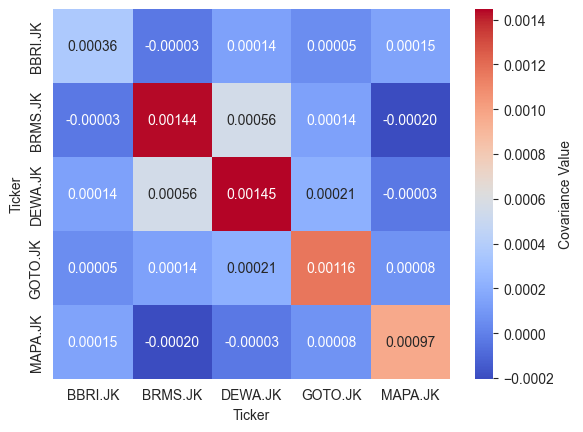

In [5]:
sns.heatmap(cov_mat, annot=True, cmap='coolwarm', fmt=".5f", cbar_kws={'label': 'Covariance Value'})

In [6]:
# Random weight on portfolio
weights = np.random.random(len(mean_returns))
weights /= np.sum(weights)

n_sims = 100
T = 100
# T is trading days

# matrix to hold average returns
mean_mat = np.full(shape=(T, len(mean_returns)), fill_value=mean_returns)

mean_mat_transpose = mean_mat.T # shape (T,Stocks)
portfolio_sims = np.full(shape=(T, n_sims), fill_value=0.0) # Store simulated portfolio

initial_portfolio = 10_000

for n in range(0, 100):
    Z = np.random.normal(size=(T, len(weights)))
    # Independent standard normal random variables
    L = np.linalg.cholesky(cov_mat) # lower triangular matrix
    daily_returns = mean_mat_transpose + np.inner(L, Z) 
    # pairwise dot product, transforms independent random normals into correlated random variables where correlation structure is consitent with covariance matrix
    portfolio_sims[:, n] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_portfolio

array([[-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.00465016,  0.00012385,  0.00081153],
       [-0.00165945,  0.00627179,  0.0

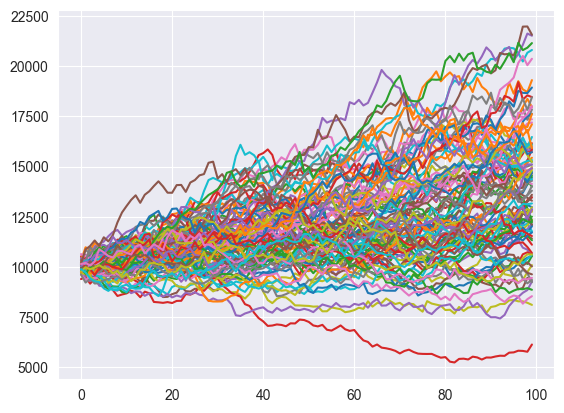

In [14]:
plt.plot(portfolio_sims)
plt.show()

* VaR represents the maximum loss expected at a given confidence level (1-alpha)
* CVaR represents average loss given that losses exceed the VaR threshold

In [18]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initial_portfolio - mcVaR(portResults, alpha=5)
CVaR = initial_portfolio - mcCVaR(portResults, alpha=5)
print('VaR:', VaR, 'cVaR:', CVaR
      )
"""
Interpretation
There is a 5% chance that the portfolio will lose at least 722$ over the simulated period. Equivalently, the portfolio’s final value in the 5% worst-case scenarios would be $10,000 - $722.25 = $9,277.75.

In the 5% worst-case scenarios, the average loss is $1,817.87.
The portfolio’s expected final value in those cases would be $10,000 - $1,817.87 = $8,182.13.
"""

VaR: 722.2537417121221 cVaR: 1817.8728724675693


'\nInterpretation\nThere is a 5% chance that the portfolio will lose at least 722$ over the simulated period. Equivalently, the portfolio’s final value in the 5% worst-case scenarios would be $10,000 - $722.25 = $9,277.75.\n\nIn the 5% worst-case scenarios, the average loss is $1,817.87.\nThe portfolio’s expected final value in those cases would be $10,000 - $1,817.87 = $8,182.13.\n'



## Antithetic Variates

Let's write an option on asset $S_1$ and another option on asset $S_2$ that is perfectly negatively correlated with $S_1$ and which currently has the same price. $S_1$ and $S_2$ satisfy the following Stochastic Differential Equations:

$\large dS_{1,t} = rdS_{1,t}dt+\sigma dS_{1,t}dz_t$

$\large dS_{2,t} = rdS_{2,t}dt-\sigma dS_{2,t}dz_t$

Since the price and volatility of the two assets are identical, so is the value of these two options. However, the variance of a portfolio pay-off containing both of these contracts is much less than the variance of the pay-off of each individual contract. In essence we are removing the large spike in probability distribution of a single contract pay-off. i.e. Basic Intuition: when one option pays out, the other does not.

To implement an antithetic variate we create a hypothetical asset which is perfectly negatively correlated with the original asset. Implementation is very simple, and if we consider the example of the European Call Option (as in last weeks video). Our simulated pay-offs are under the following $S_t$ dynamics:

$\large S_{t+\Delta t} = S_{t} \exp( \nu \Delta t + \sigma (z_{t+\Delta t}- z_t) )$

Where $(z_{t+\Delta t}- z_t) \sim N(0,\Delta t) \sim \sqrt{\Delta t} N(0,1) \sim \sqrt{\Delta t} \epsilon_i$

### Contract Simulation

- $\large C_{T,i} = max(0, S \exp( \nu \Delta T + \sigma \sqrt{T} (\epsilon_i) ) - K)$

- $\large \bar{C}_{T,i} = max(0, S \exp( \nu \Delta T + \sigma \sqrt{T} (-\epsilon_i) ) - K)$

In [20]:
# initial derivative parameters
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.015            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations

market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years
print(T)

# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    lnSt1 = lnS
    lnSt2 = lnS
    for j in range(N):
        # Perfectly Negatively Correlated Assets
        epsilon = np.random.normal()
        lnSt1 = lnSt1 + nudt + volsdt*epsilon
        lnSt2 = lnSt2 + nudt - volsdt*epsilon

    ST1 = np.exp(lnSt1)
    ST2 = np.exp(lnSt2)
    CT = 0.5 * ( max(0, ST1 - K) + max(0, ST2 - K) )
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

0.1643835616438356
Call value is $3.81 with SE +/- 0.03
